#LSTM 

The first attempt of a global LSTM model. 

In this example I have used two time series to train the model. Both from the dataset Hourly Energy Consumption from kaggle (https://www.kaggle.com/robikscube/hourly-energy-consumption). 

### Import packages

In [3]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt
from google.colab import files
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [4]:
import os
import time

## Load data

In [5]:
uploaded = files.upload()

Saving NI_hourly.csv to NI_hourly.csv
Saving AEP_hourly.csv to AEP_hourly.csv


In [6]:
import io
df = pd.read_csv(io.BytesIO(uploaded['NI_hourly.csv']))


In [7]:
df2 = pd.read_csv(io.BytesIO(uploaded['AEP_hourly.csv']))

## Exploring data

In [8]:
def exploredata(dataframe):
  """A function to check shape of the time series, 
  if there exist missing data, set 'Datetime' as index 
  and plot series."""
  
  #print shape
  print("Shape: ", dataframe.shape)

  #head dataframe
  print(dataframe.head())

  #defining the datetime as index
  dataframe.set_index("Datetime", inplace = True)

  #check for missing values
  missing_values = dataframe.isnull().sum().sum()
  if missing_values == 0:
    print("No missing values in this time series.")
  else: 
    print("Missing values! There is ",missing_values, " missing values." )
  
  #new shape
  print("Shape after new index:", dataframe.shape)

  #plotdata
  color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
  dataframe.plot(style='.', figsize=(15,5), color=color_pal[0], title='NI hourly energy consumption')
  plt.show()

Shape:  (58450, 2)
              Datetime   NI_MW
0  2004-12-31 01:00:00  9810.0
1  2004-12-31 02:00:00  9001.0
2  2004-12-31 03:00:00  8509.0
3  2004-12-31 04:00:00  8278.0
4  2004-12-31 05:00:00  8089.0
No missing values in this time series.
Shape after new index: (58450, 1)


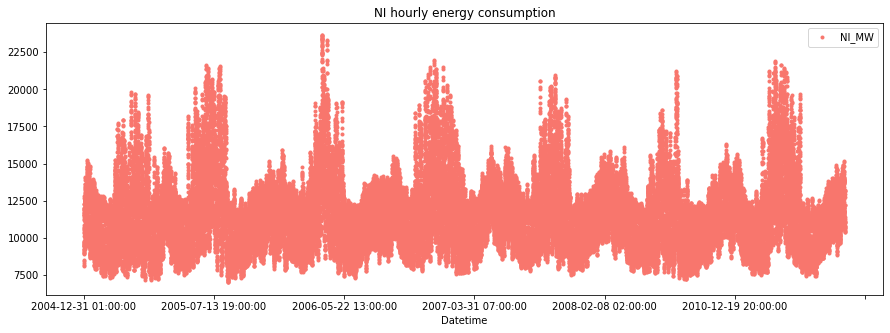

In [9]:
exploredata(df)

Shape:  (121273, 2)
              Datetime   AEP_MW
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0
No missing values in this time series.
Shape after new index: (121273, 1)


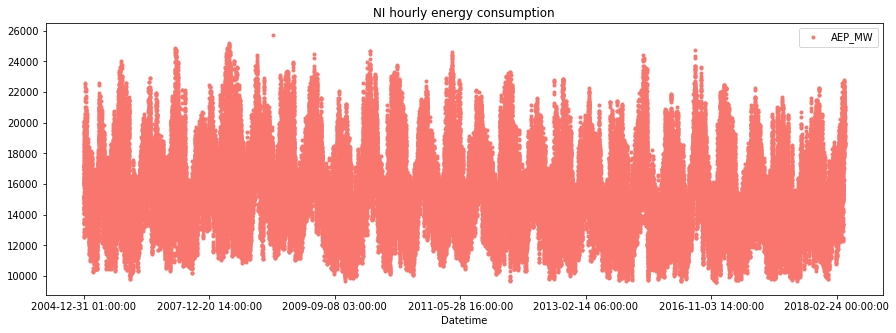

In [10]:
exploredata(df2)

## Preprocessing of data
Divide into train and test set, and normalize.

In [11]:
##SPØRSMÅL: burde ein heller normalisera på tvers av alle tidsrekkene?

def splitAndNormalize(dataframe):
  """A function that splits the series into training and testing data sets, 
  normalize the data, and convert them to tensors."""

  #split
  split_date = dataframe.index[int(len(dataframe.index)*0.8)]
  df_train = dataframe.loc[dataframe.index <= split_date].copy()
  df_test = dataframe.loc[dataframe.index > split_date].copy()

  #normalize
  scaler = StandardScaler()
  train = scaler.fit_transform(df_train)
  test = scaler.transform(df_test)

  #convert to tensors
  train = torch.FloatTensor(train)
  test = torch.FloatTensor(test)

  return train, test, scaler

In [12]:
train1, test1, scaler1 = splitAndNormalize(df)
train2, test2, scaler2 = splitAndNormalize(df2)

In [13]:
train1.shape

torch.Size([43881, 1])

In [79]:
train = [train1, train2]
test = [test1, test2]

In [15]:
def create_sequence_data (input_data, seq_len):
  inout_seq = []
  S = len(input_data)
  for serie in input_data:
    L = len(serie)
    for i in range (L - seq_len):
      train_seq = serie[i : i+seq_len]
      train_label = serie[i+seq_len : i+seq_len+1]
      inout_seq.append((train_seq, train_label))
  return inout_seq

In [16]:
sequence_length = 25

In [17]:
# create sequence training data for both time series
train_seq = create_sequence_data(train, sequence_length)

In [18]:
#collect all sequences in one tensor, and all labels in one tensor
seqs = [ss[0] for ss in train_seq]
labels = [ss[1] for ss in train_seq]
torch_labels = torch.FloatTensor(labels)
torch_seqs = torch.stack(seqs)
print('Type:', type(torch_seqs))

Type: <class 'torch.Tensor'>


In [19]:
#create TensorDataset
from torch.utils.data import TensorDataset
torch_ds = TensorDataset(torch_seqs,torch_labels)

In [20]:
#create batchdata using DataLoader
from torch.utils.data import  DataLoader
batch_size = 128
train_loader = DataLoader(torch_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [21]:
# checking if GPU is available
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(is_cuda)

True


## LSTM pytorch
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html


In [80]:
#Parameters
input_size = 1
hidden_layer_size = 10
output_size = 1
lr = 0.001 #learning rate
num_epochs = 20 
batch_size = 128
n_layers = 3

In [81]:
class LSTM(nn.Module):
    def __init__(self, input_size = input_size, hidden_layer_size = hidden_layer_size, output_size = output_size, n_layers = n_layers):
      super(LSTM, self).__init__()

      self.hidden_layer_size = hidden_layer_size
      self.n_layers = n_layers

      self.lstm = nn.LSTM(input_size, hidden_layer_size, n_layers, batch_first=True)
      self.linear = nn.Linear(hidden_layer_size, output_size)
      self.relu = nn.ReLU()

      self.hidden_cell = (torch.zeros(self.n_layers,batch_size,self.hidden_layer_size).to(device), 
                          torch.zeros(self.n_layers,batch_size,self.hidden_layer_size).to(device))
      
    def forward(self, input_seq):
      lstm_out, self.hidden_cell = self.lstm(input_seq)
      out1 =  self.relu(lstm_out[:,-1])
      out2 = self.linear(out1)
      
      return out2


### Train model

In [36]:
model = LSTM() 
model.to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
losses = []
model.train()
for i in range (num_epochs):
  print('Epoch:', i)
  for seq, label in train_loader:
    optimizer.zero_grad()
    model.hidden_cell = (torch.zeros(n_layers, batch_size, hidden_layer_size).to(device), 
                          torch.zeros(n_layers, batch_size, hidden_layer_size).to(device))
    y_pred = model(seq.to(device))
    loss = loss_function(y_pred, label.to(device))
    loss.backward()
    optimizer.step()
  losses.append(loss)

Epoch: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19


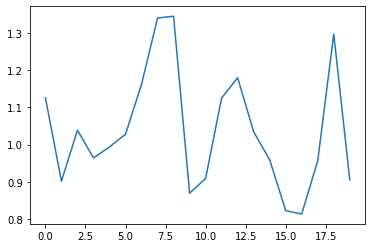

In [38]:
plt.plot(losses)

### Make Predictions

In [82]:
test1_seq = create_sequence_data(test,sequence_length)
testseqs=[ss[0] for ss in test1_seq]
testlabels = [ss[1] for ss in test1_seq]
ttestlabels = torch.FloatTensor(testlabels)
ttestseqs = torch.stack(testseqs)

In [83]:
test_ds = TensorDataset(ttestseqs,ttestlabels)

In [84]:
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [85]:
predicted = []
model.eval()
for seq, label in test_loader:
    with torch.no_grad():
      model.hidden_cell = (torch.zeros(n_layers, batch_size, hidden_layer_size).to(device), 
                          torch.zeros(n_layers, batch_size, hidden_layer_size).to(device))
      y_pred = model(seq.to(device))[-1]
      predicted.append(y_pred)

In [86]:
print(len(predicted))
print(len(test_loader))

347
347


In [87]:
#backscale results
actual_predictions = scaler1.inverse_transform(np.array(predicted).reshape(-1, 1))
actual = scaler1.inverse_transform(np.array(testlabels).reshape(-1, 1))

1


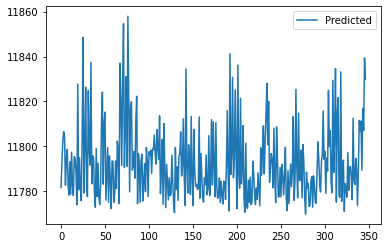

In [90]:
print(len(actual_predictions[0]))
plt.figure()
plt.plot(actual_predictions, label='Predicted')
plt.legend()
plt.show()

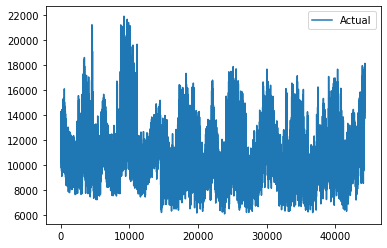

In [95]:
plt.plot(actual, label = 'Actual')
plt.legend()
plt.show()